Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import (
    TimeSeriesTransformerConfig,
    TimeSeriesTransformerForPrediction,
)
from gluonts.time_feature import (
    get_lags_for_frequency,
    time_features_from_frequency_str,
)
from gluonts.dataset.pandas import PandasDataset
from gluonts.itertools import Map
from datasets import Dataset, DatasetDict, Features, Value, Sequence
from functools import lru_cache, partial
from gluonts.dataset.field_names import FieldName

from accelerate import Accelerator
from torch.optim import AdamW
import matplotlib.dates as mdates
import sys
from pathlib import Path

# Get the parent directory
parent_dir = Path.cwd().parent.parent

# Ensure it's not already in sys.path
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
from shared.metrics import print_evaluation_metrics
from shared.helpers import store_model
from shared.transformer import create_train_dataloader, create_test_dataloader, transform_start_field, TransformerModel

/home/samuell/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/samuell/.local/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


Load dataset and prepare df

In [2]:
file_path = "../data/parsed_dataset.csv"
date_column = "period"
target_column = "value"
id_column = "item_id"

df = pd.read_csv(file_path, parse_dates=[date_column])[[date_column, target_column]]
df = df.groupby(date_column).sum().reset_index()
df = df.dropna()

df[id_column] = "id"
df[target_column] = df[target_column].fillna(0)
df.set_index(date_column, inplace=True)

unique_dates = df.index.unique()

Train, validation, test split

In [3]:
df_train = df[df.index < unique_dates[int(len(unique_dates) *0.9)]]
df_test = df

In [4]:
len(df_train), len(df), len(df_test)

(10320, 11467, 11467)

Process fields for dataset

In [5]:
class ProcessStartField:
    ts_id = 0

    def __call__(self, data):
        data["start"] = data["start"].to_timestamp()
        data["feat_static_cat"] = [self.ts_id]
        data["feat_dynamic_real"] = None
        # data["item_id"] = f"T{self.ts_id+1}"
        self.ts_id += 1

        return data

Features for dataset

In [6]:
features = Features(
    {
        "start": Value("timestamp[s]"),
        "target": Sequence(Value("float32")),
        "feat_static_cat": Sequence(Value("uint64")),
        # "feat_static_real":  Sequence(Value("float32")),
        "feat_dynamic_real": Sequence(Sequence(Value("uint64"))),
        # "feat_dynamic_cat": Sequence(Sequence(Value("uint64"))),
        "item_id": Value("string"),
    }
)

Create datasets from data frames

In [7]:
ds_train = PandasDataset.from_long_dataframe(
    df_train, target=target_column, item_id=id_column
)
ds_test = PandasDataset.from_long_dataframe(
    df_test, target=target_column, item_id=id_column
)

process_start = ProcessStartField()
process_start.ts_id = 0
list_ds_train = list(Map(process_start, ds_train))
process_start.ts_id = 0
list_ds_test = list(Map(process_start, ds_test))


train_dataset = Dataset.from_list(list_ds_train, features=features)
test_dataset = Dataset.from_list(list_ds_test, features=features)

In [8]:
freq = "H"
prediction_length = int(len(unique_dates) *0.1)

In [9]:
prediction_length

1146

In [10]:
train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

In [11]:
lags_sequence = get_lags_for_frequency(freq)

In [12]:
time_features = time_features_from_frequency_str(freq)

In [13]:
config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,
    # we'll add 2 time features ("month of year" and "age"):
    num_time_features=len(time_features) + 1,
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=1,
    cardinality=[len(train_dataset)],
    # the model will learn an embedding of size 2 for each one of the possible values:
    embedding_dimension=[2],
    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32,
)

model = TimeSeriesTransformerForPrediction(config)

In [14]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=32,
    num_batches_per_epoch=1,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=16,
)


In [15]:
accelerator = Accelerator()
device = accelerator.device
import pickle

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)
model.train()
for epoch in range(40):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()
        if idx % 100 == 0:
            print(loss.item())
    pickle.dump(model, open(f"transformer_model{epoch}.pkl", "wb"))
    pickle.dump(optimizer, open(f"transformer_optimizer{epoch}.pkl", "wb"))
    pickle.dump(accelerator, open(f"transformer_accelerator{epoch}.pkl", "wb"))

{'weight': Parameter containing:
tensor([[ 0.0051, -0.0303]], requires_grad=True), 'input': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), 'padding_idx': -1, 'scale_grad_by_freq': False, 'sparse': False}
{'weight': Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.8415,  0.5332,  0.3110,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.9093,  0.9021,  0.5911,  ...,  1.0000,  1.0000,  1.0000],
        ...,
        [-0.9455,  0.4233, -0.6807,  ..., -0.3531,  0.4658,  0.8192],
        [-0.7848, -0.1250, -0.4191,  ..., -0.3536,  0.4655,  0.8191],
        [ 0.0975, -0.6347, -0.1160,  ..., -0.3541,  0.4653,  0.8190]]), 'input': tensor([   0,    1,    2,  ..., 2289, 2290, 2291]), 'padding_idx': -1, 'scale_grad_by_freq': False, 'sparse': False}
{'weight': Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.8415,  0.5332,  0.31

In [16]:
model.eval()

TimeSeriesTransformerForPrediction(
  (model): TimeSeriesTransformerModel(
    (scaler): TimeSeriesMeanScaler()
    (embedder): TimeSeriesFeatureEmbedder(
      (embedders): ModuleList(
        (0): Embedding(1, 2)
      )
    )
    (encoder): TimeSeriesTransformerEncoder(
      (value_embedding): TimeSeriesValueEmbedding(
        (value_projection): Linear(in_features=49, out_features=32, bias=False)
      )
      (embed_positions): TimeSeriesSinusoidalPositionalEmbedding(3438, 32)
      (layers): ModuleList(
        (0-3): 4 x TimeSeriesTransformerEncoderLayer(
          (self_attn): TimeSeriesTransformerAttention(
            (k_proj): Linear(in_features=32, out_features=32, bias=True)
            (v_proj): Linear(in_features=32, out_features=32, bias=True)
            (q_proj): Linear(in_features=32, out_features=32, bias=True)
            (out_proj): Linear(in_features=32, out_features=32, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((32,), eps=1e-05, element

In [16]:
forecasts = []
accelerator = Accelerator()
device = accelerator.device

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())

{'weight': Parameter containing:
tensor([[-4.0807e-05, -4.2372e-02]], requires_grad=True), 'input': tensor([0]), 'padding_idx': -1, 'scale_grad_by_freq': False, 'sparse': False}
{'weight': Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.8415,  0.5332,  0.3110,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.9093,  0.9021,  0.5911,  ...,  1.0000,  1.0000,  1.0000],
        ...,
        [-0.9455,  0.4233, -0.6807,  ..., -0.3531,  0.4658,  0.8192],
        [-0.7848, -0.1250, -0.4191,  ..., -0.3536,  0.4655,  0.8191],
        [ 0.0975, -0.6347, -0.1160,  ..., -0.3541,  0.4653,  0.8190]]), 'input': tensor([   0,    1,    2,  ..., 2289, 2290, 2291]), 'padding_idx': -1, 'scale_grad_by_freq': False, 'sparse': False}
{'weight': Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.8415,  0.5332,  0.3110,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.9093,  0.9021,  0.5911,  ...,  1.0000,  1.0

In [17]:
forecasts = np.vstack(forecasts)
forecast_median = np.median(forecasts, 1)

In [18]:
non_zero = []
 
for i in forecast_median[0]:
    removed_initial_one = i-1
    if removed_initial_one == 0:
        non_zero.append(removed_initial_one+sys.float_info.min)
    else:
        non_zero.append(removed_initial_one)

In [19]:
ground_truth = np.array(test_dataset[0]["target"][-prediction_length:])
print_evaluation_metrics(non_zero, ground_truth-1, df_train[target_column]-1)

Evaluation Metrics:
MSE: 1090355005.46
RMSE: 33020.52
MAE: 25499.64
MAPE: 10.05
SMAPE: 9.54
MASE: 3.48


In [20]:
def plot(ts_index):
    fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
    

    index = pd.period_range(
        start=test_dataset[ts_index][FieldName.START],
        periods=len(test_dataset[ts_index][FieldName.TARGET]),
        freq=freq,
    ).to_timestamp()

    ax.plot(
        index[-int(len(unique_dates) *0.1):],
        (np.array(test_dataset[ts_index]["target"][-int(len(unique_dates) *0.1):])-1),
        label="actual",
    )

    ax.plot(
        index[-int(len(unique_dates) *0.1):],
        np.median([non_zero], axis=0),
        label="prediction",
    )

   
    ax.set_title("Prediction Transformer")
    ax.set_ylabel("New Deaths")
    ax.set_xlabel(date_column)
    ax.legend()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.show()

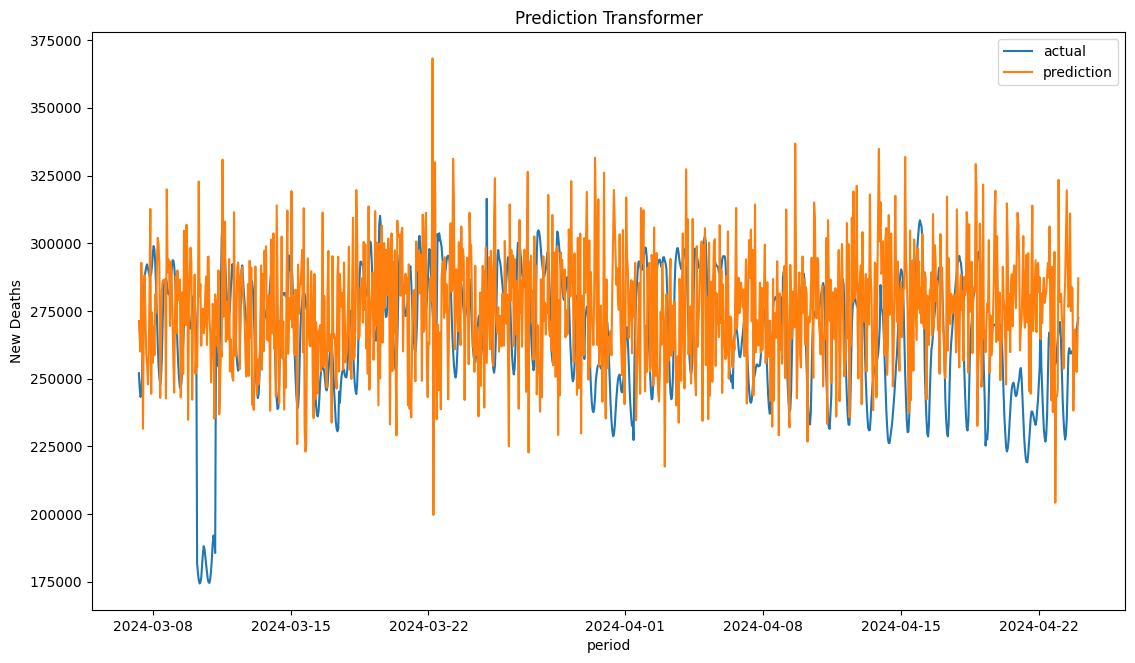

In [21]:
plot(0)

In [22]:
model_class = TransformerModel(model, config, target_column, id_column, 16, "H")
store_model(model_class, "transformer")

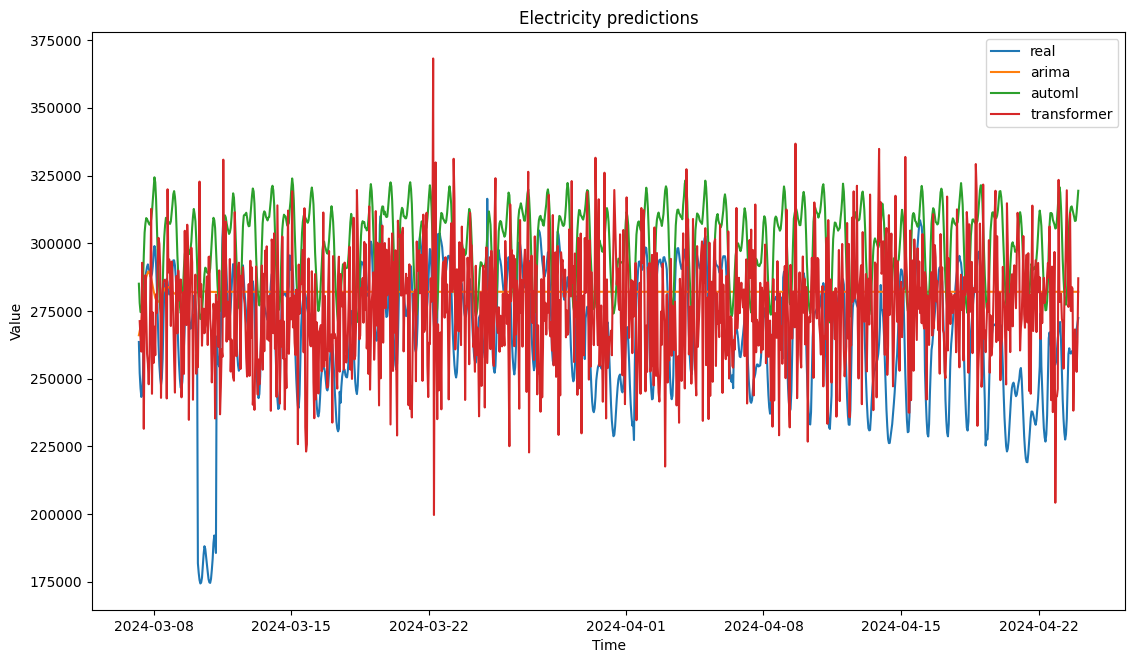

In [23]:
from shared.helpers import store_predictions_and_create_graph
store_predictions_and_create_graph("transformer", unique_dates[-len(non_zero):], non_zero, ground_truth-1, "Electricity")